# Interactions

This is a collection of interactions, mostly from the book. If you have are reading a print version of the book, or are reading it online via Github or nbviewer you will be unable to run the interactions.

So I have created this notebook. Here is how you run an interaction if you do not have IPython installed on your computer.

1. Go to try.juptyer.org in your browser. It will launch a temporary notebook server for you.

2. Click the **New** button and select `Python 3`. This will create a new notebook that will run Python 3 for you in your browser.

3. Copy the entire contents of a cell from this notebook and paste it into a 'code' cell in the notebook on your browser. 

4. Press CTRL+ENTER to execute the cell.

5. Have fun! Change code. Play. Experiment. Hack.

Your server and notebook is not permanently saved. Once you close the session your data is lost. Yes, it says it is saving your file if you press save, and you can see it in the directory. But that is just happening in a Docker container that will be deleted as soon as you close the window. Copy and paste any changes you want to keep to an external file.

Of course if you have IPython installed you can download this notebook and run it on your own computer. Type

    ipython notebook
    
in a command prompt from the directory where you downloaded this file. Click on the name of this file to open it.

# Experimenting with FPF'


The Kalman filter uses the equation $P^- = FPF^\mathsf{T}$ to compute the prior of the covariance matrix during the prediction step, where P is the covariance matrix and F is the system transistion function. For a Newtonian system $x = \dot{x}\Delta t + x_0$ F might look like

$$F = \begin{bmatrix}1 & \Delta t\\0 & 1\end{bmatrix}$$

$FPF^\mathsf{T}$ alters P by taking the correlation between the position ($x$) and velocity ($\dot{x}$). This interactive plot lets you see the effect of different designs of F has on this value. For example,

* what if $x$ is not correlated to $\dot{x}$? (set F01 to 0)

* what if $x = 2\dot{x}\Delta t + x_0$? (set F01 to 2)

*  what if $x = \dot{x}\Delta t + 2*x_0$? (set F00 to 2)

* what if $x = \dot{x}\Delta t$?  (set F00 to 0)

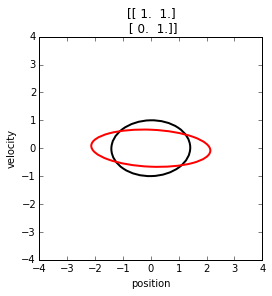

In [1]:
%matplotlib inline
from IPython.html.widgets import interact, interactive, fixed
import IPython.html.widgets as widgets
import numpy as np
import numpy.linalg as linalg
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_covariance_ellipse(x, P, edgecolor='k'):
    U,s,v = linalg.svd(P)
    angle = math.atan2(U[1,0],U[0,0])
    width  = math.sqrt(s[0]) * 2
    height = math.sqrt(s[1]) * 2

    ax = plt.gca()
    e = Ellipse(xy=(0, 0), width=width, height=height, angle=angle,
                edgecolor=edgecolor, facecolor='none',
                lw=2, ls='solid')
    ax.add_patch(e)
    ax.set_aspect('equal')
    
    
def plot_FPFT(F00, F01, F10, F11, covar):
    
    dt = 1.
    x = np.array((0, 0.))
    P = np.array(((1, covar), (covar, 2)))
    F = np.array(((F00, F01), (F10, F11)))

    plot_covariance_ellipse(x, P)
    plot_covariance_ellipse(x, np.dot(F, P).dot(F.T), edgecolor='r')
    #plt.axis('equal')
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.title(str(F))
    plt.xlabel('position')
    plt.ylabel('velocity')
                 
interact(plot_FPFT, 
         F00=widgets.IntSlider(value=1, min=0, max=2.), 
         F01=widgets.FloatSlider(value=1, min=0., max=2., description='F01(dt)'),
         F10=widgets.FloatSlider(value=0, min=0., max=2.),
         F11=widgets.FloatSlider(value=1, min=0., max=2.),
         covar=widgets.FloatSlider(value=0, min=0, max=1.));

# Covariance Ellipse

See the effect of varying the variances and covariance of a covariance matrix of the form

$$\begin{bmatrix}\texttt{var}_x & \texttt{cov}_xy \\ \texttt{cov}_xy & \texttt{var}_y\end{bmatrix}$$

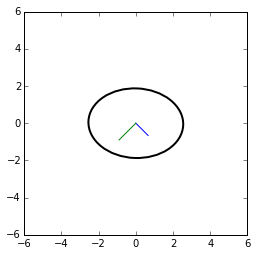

In [2]:
%matplotlib inline
from IPython.html.widgets import interact, interactive, fixed
from IPython.html.widgets import FloatSlider
from math import cos, sin, pi, atan2, sqrt
import  numpy.linalg as linalg
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_covariance_ellipse(P):
    U,s,v = linalg.svd(P)
    angle = atan2(U[1,0],U[0,0])
    width  = sqrt(s[0]) * 2
    height = sqrt(s[1]) * 2

    ax = plt.gca()
    e = Ellipse(xy=(0, 0), width=width, height=height, angle=angle,
                edgecolor='k', facecolor='none',
                lw=2, ls='solid')
    ax.add_patch(e)
    h, w = height/4, width/4
    plt.plot([0, h*cos(angle+pi/2)], [0, h*sin(angle+pi/2)])
    plt.plot([0, w*cos(angle)],      [0, w*sin(angle)])

def plot_covariance(var_x, var_y, cov_xy):
    P = [[var_x, cov_xy], [cov_xy, var_y]]
    plot_covariance_ellipse(P)
    plt.xlim(-6, 6)
    plt.gca().set_aspect('equal')
    plt.ylim(-6, 6)
    plt.show()

interact (plot_covariance,           
          var_x=FloatSlider(value=5., min=0, max=20.), 
          var_y=FloatSlider(value=5., min=0., max=20.), 
          cov_xy=FloatSlider(value=1.5, min=0.0, max=50, step=.2));


# g-h Filter

Experiment with various values for g-h filter parameters.

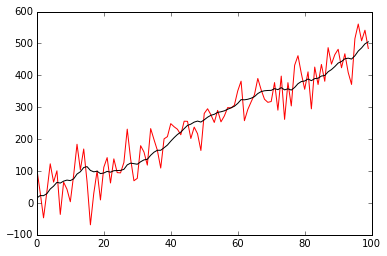

In [3]:
%matplotlib inline
from IPython.html.widgets import interact, interactive, fixed
import IPython.html.widgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random

def gen_data(x0, dx, count, noise_factor):
    return [x0 + dx*i + random.randn()*noise_factor for i in range (count)]

def g_h_filter(data, x0, dx, g, h, dt=1., pred=None):    
    x = x0
    results = []
    for z in data:
        #prediction step
        x_est = x + (dx*dt)
        dx = dx        
        if pred is not None:
            pred.append(x_est)
        
        # update step
        residual = z - x_est
        dx = dx    + h * (residual) / dt
        x  = x_est + g * residual     
        results.append(x)  
    return np.array(results)

zs = gen_data(x0=5, dx=5, count=100, noise_factor=50)

def interactive_gh(x, dx, g, h):
    data = g_h_filter(data=zs, x0=x, dx=dx, dt=1.,g=g, h=h)
    plt.plot(zs, color='r')
    plt.plot(data, color='k')
    plt.show()

interact (interactive_gh,           
          x=widgets.FloatSlider(value=0., min=-50, max=50.), 
          dx=widgets.FloatSlider(value=5., min=-50., max=50.), 
          g=widgets.FloatSlider(value=0.1, min=0.01, max=2, step=.02), 
          h=widgets.FloatSlider(value=0.02, min=0.0, max=0.5, step=0.01));